In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, substring, col, when, desc, min, max, sum, \
split, udf, count, countDistinct, rand, struct, isnan, isnull, from_unixtime, dayofmonth, month, datediff, to_date, lit, current_date
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

In [2]:
# Create the spark session and load the dataframe
spark = SparkSession \
    .builder \
    .appName("Churn Analysis") \
    .getOrCreate()

path = "D:\OneDrive - NITT\Custom_Download\mini_sparkify_event_data.json"
df = spark.read.json(path)
df.persist()

df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [3]:
df.createOrReplaceTempView('logs')

In [4]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [5]:
df.where(col('firstName').isNull()).show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [6]:
df.where(col('artist').isNull()).show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null| Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null| Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null| Logged In|    Mi

In [7]:
df = df.where(col('auth') != 'Logged Out')

In [8]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
df.show(n=5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [10]:
df.groupBy('Page').count().show()

+--------------------+------+
|                Page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10118|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   509|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1477|
|             Upgrade|   499|
|               Error|   253|
|      Submit Upgrade|   159|
| Submit Registration|     5|
+--------------------+------+
only showing top 20 rows



In [11]:
spark.sql('SELECT COUNT(DISTINCT userId) AS nb_users FROM logs').show()

+--------+
|nb_users|
+--------+
|     226|
+--------+



In [12]:
# Create a dataset with all user ID's and a label which specifies whether that individual churned or not

# First a dataset with users who churned
churn = spark.sql('SELECT DISTINCT userId, 1 as churn FROM logs WHERE Page = "Cancellation Confirmation"')

# Then the other users
no_churn = spark.sql('SELECT DISTINCT userId, 0 as churn FROM logs \
                      WHERE userId NOT IN (SELECT DISTINCT userId FROM logs WHERE Page = "Cancellation Confirmation")')

# Create a dataframe from the union of the two, shuffling the rows
churn_df = churn.union(no_churn)
churn_df.createOrReplaceTempView('churn')
churn_df = spark.sql('SELECT * FROM churn ORDER BY RAND()')
churn_df.createOrReplaceTempView('churn')

# Check that we have the right number of users
churn_df.count()

226

In [13]:
# visualize the distribution of users between churning or not
churn_pd_df = churn_df.toPandas()
churn_pd_df.groupby('churn', as_index=False).count()

,churn,userId
0,0,174
1,1,52


In [14]:
# Join our churn dataset to our full dataset to add a column
joined_df = df.join(churn_df, on='userId')

# Use this column to create some aggregates, first comparing the level of the account
joined_df.groupBy(['churn', 'level']).count().show(5)

+-----+-----+------+
|churn|level| count|
+-----+-----+------+
|    0| free| 43430|
|    0| paid|189957|
|    1| paid| 32476|
|    1| free| 12388|
+-----+-----+------+



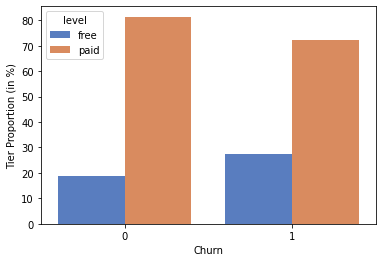

In [15]:
# Build a data visualization: a grouped bar chart of proportions
level_df = joined_df.groupBy(['churn', 'level']).count().toPandas()
churn_sum = level_df.groupby('churn', as_index=False).sum()
level_df['proportion'] = (level_df.join(churn_sum, on = 'churn', lsuffix='_1')['count_1']/level_df.join(churn_sum, on = 'churn', lsuffix='_1')['count'])*100

g = sns.barplot(x="churn", y="proportion", hue="level", data=level_df,
                palette="muted")
g.set(xlabel='Churn', ylabel="Tier Proportion (in %)")
plt.show();

In [16]:
joined_df.groupBy('churn').avg('length').show(5)

+-----+------------------+
|churn|       avg(length)|
+-----+------------------+
|    1| 248.6327956440638|
|    0|249.20913538881527|
+-----+------------------+



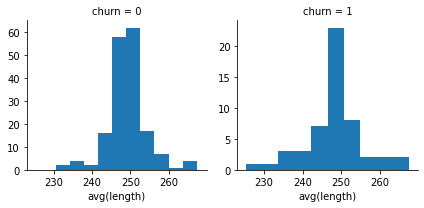

In [17]:
# get the average length for every user, keeping the churn information and transform to a Pandas dataframe
length_df = joined_df.groupBy(['userId', 'churn']).avg('length').toPandas()

# visualize the distribution of length between two groups of users
g = sns.FacetGrid(length_df, col="churn", sharey=False)
g.map(plt.hist, "avg(length)");

In [18]:
# The itemInSession variable, which represents the rank fo the song in the current sessionk
joined_df.groupBy('churn').avg('itemInSession').show(5)

+-----+------------------+
|churn|avg(itemInSession)|
+-----+------------------+
|    1|109.23299304564907|
|    0|115.94533542999396|
+-----+------------------+



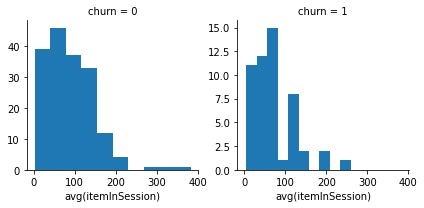

In [19]:
# Similar to length, we visualize the distribution between both groups
item_df = joined_df.groupBy(['userId','churn']).avg('itemInSession').toPandas()
g = sns.FacetGrid(item_df, col="churn", sharey=False)
g.map(plt.hist, "avg(itemInSession)");

In [20]:
# Let's create a variable representing the state
joined_df = joined_df.withColumn('state', substring(col("location"), -2, 3))

# See the most present states for people who churned 
joined_df.groupBy(['churn', 'state']).count().where(joined_df['churn'] == 0).sort(col('count').desc()).show(5)
joined_df.groupBy(['churn', 'state']).count().where(joined_df['churn'] == 1).sort(col('count').desc()).show(5)

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    0|   CA|39158|
|    0|   PA|23708|
|    0|   TX|22200|
|    0|   NH|18637|
|    0|   FL|11427|
+-----+-----+-----+
only showing top 5 rows

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    1|   CA| 7613|
|    1|   CO| 4317|
|    1|   MS| 3839|
|    1|   WA| 3526|
|    1|   OH| 3173|
+-----+-----+-----+
only showing top 5 rows



In [21]:
# Study potential differences based on ts
joined_df.groupBy('churn').avg('ts').show(5)

+-----+--------------------+
|churn|             avg(ts)|
+-----+--------------------+
|    1|1.539919263874465E12|
|    0|1.541159010797756...|
+-----+--------------------+



In [22]:
# the ts column is actually a unix timestamp, which we convert to a date format
joined_df = joined_df.withColumn('date', from_unixtime((col('ts')/1000)).cast(DateType()))

In [23]:
# once this is done, we can create several time based features
# first, extract day and month from the date column
joined_df = joined_df.withColumn('day', dayofmonth('date')).withColumn('month', month('date'))

In [24]:
day_df = joined_df.groupBy(['userId', 'day']).agg(countDistinct('sessionId')).groupBy('userId').avg('count(sessionId)').withColumnRenamed('avg(count(sessionId))', 'daily_sessions')

In [25]:
month_df = joined_df.groupBy(['userId', 'month']).agg(countDistinct('sessionId')).groupBy('userId').avg('count(sessionId)').withColumnRenamed('avg(count(sessionId))', 'monthly_sessions')

In [26]:
# then for a given user get the average number of distinct sessions per day and per month

# join this information back to the original joined_df for each row for a given userId, it will be used later
joined_df = joined_df.join(day_df, on='userId').join(month_df, on='userId')

In [27]:
joined_df.columns

['userId',
 'artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'churn',
 'state',
 'date',
 'day',
 'month',
 'daily_sessions',
 'monthly_sessions']

In [28]:
# Compare number of daily and monthly sessions for the two groups of users
joined_df.groupBy('churn').avg('daily_sessions').show()
joined_df.groupBy('churn').avg('monthly_sessions').show()

+-----+-------------------+
|churn|avg(daily_sessions)|
+-----+-------------------+
|    1| 1.3967687741695773|
|    0| 1.7275042165377033|
+-----+-------------------+

+-----+---------------------+
|churn|avg(monthly_sessions)|
+-----+---------------------+
|    1|   10.477721558487875|
|    0|   12.582251082249577|
+-----+---------------------+



In [29]:
# registration is also unix timestamp, representing the registration date. Convert them to an actual date
joined_df = joined_df.withColumn('registration_date', from_unixtime((col('registration')/1000)).cast(DateType()))

# create a new feature capturing the number of days since registration
joined_df = joined_df.withColumn('days_since_registration', datediff(current_date(), col('registration_date')))

# create a new feature capturing the month of the year when they registered, to account for potential promotions
joined_df = joined_df.withColumn('month_registration', month('registration_date'))

In [30]:
# Study potential differences based on user agent
joined_df.groupBy(['churn', 'userAgent']).count().where(joined_df['churn'] == 0).sort(col('count').desc()).show(5)
joined_df.groupBy(['churn', 'userAgent']).count().where(joined_df['churn'] == 1).sort(col('count').desc()).show(5)

+-----+--------------------+-----+
|churn|           userAgent|count|
+-----+--------------------+-----+
|    0|"Mozilla/5.0 (Win...|18226|
|    0|"Mozilla/5.0 (Mac...|16298|
|    0|"Mozilla/5.0 (Mac...|15914|
|    0|"Mozilla/5.0 (Win...|15237|
|    0|Mozilla/5.0 (Wind...|15224|
+-----+--------------------+-----+
only showing top 5 rows

+-----+--------------------+-----+
|churn|           userAgent|count|
+-----+--------------------+-----+
|    1|"Mozilla/5.0 (Mac...| 4736|
|    1|"Mozilla/5.0 (Win...| 4525|
|    1|Mozilla/5.0 (Wind...| 3437|
|    1|"Mozilla/5.0 (Mac...| 2534|
|    1|Mozilla/5.0 (Maci...| 2462|
+-----+--------------------+-----+
only showing top 5 rows



In [31]:
# For a given user we compute number of downgrades, upgrades, thumbs up, thumbs down, add friend, add to playlist, roll advert

# Create a column for each of these events, with a 1 each time they occur
for c in ['Downgrade', 'Roll Advert', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Thumbs Up']:
    joined_df = joined_df.withColumn(c, (joined_df['Page'] == c).cast(IntegerType()))
    
# Prepare data for the pipeline
features_df = joined_df.groupBy('userId').agg(avg('itemInSession'), 
                                              avg('length'),
                                              min('daily_sessions'),
                                              min('monthly_sessions'),
                                              min('days_since_registration'),
                                              min('month_registration'),
                                            max('level'), 
                                            max('userAgent'),
                                           max('state'),
                                           sum('Downgrade'),
                                           sum('Roll Advert'),
                                           sum('Thumbs Down'),
                                           sum('Add to Playlist'),
                                           sum('Add Friend'),
                                           sum('Thumbs Up'),
                                           max('churn'))

features_df = features_df.select(col('avg(itemInSession)').alias('itemInSession'),
                                 col('avg(length)').alias('length'),
                                 col('min(daily_sessions)').alias('daily_sessions'),
                                 col('min(monthly_sessions)').alias('monthly_sessions'),
                                 col('min(days_since_registration)').alias('days_since_registration'),
                                 col('min(month_registration)').alias('month_registration'),
                  col('max(level)').alias('level'),
                  col('max(userAgent)').alias('userAgent'),
                  col('max(state)').alias('state'),
                  col('sum(Downgrade)').alias('downgrade'),
                  col('sum(Roll Advert)').alias('rollAdvert'),
                  col('sum(Thumbs Down)').alias('thumbsDown'),
                  col('sum(Add to Playlist)').alias('addToPlaylist'),
                  col('sum(Add Friend)').alias('addFriend'),
                  col('sum(Thumbs Up)').alias('thumbsUp'),
                  col('max(churn)').alias('label'))

In [32]:
# Visualize the presence of potential null values
features_df.select([count(when(isnull(c), c)).alias(c) for c in features_df.columns]).show()

# Remove these null values
features_df = features_df.where(col("userAgent").isNotNull()).where(col("state").isNotNull())

+-------------+------+--------------+----------------+-----------------------+------------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+
|itemInSession|length|daily_sessions|monthly_sessions|days_since_registration|month_registration|level|userAgent|state|downgrade|rollAdvert|thumbsDown|addToPlaylist|addFriend|thumbsUp|label|
+-------------+------+--------------+----------------+-----------------------+------------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+
|            0|     1|             0|               0|                      1|                 1|    0|        1|    1|        0|         0|         0|            0|        0|       0|    0|
+-------------+------+--------------+----------------+-----------------------+------------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+



In [33]:
# We first create a pipeline to prepare our data for modeling
indexer_state = StringIndexer(inputCol='state', outputCol='state_index')
indexer_level = StringIndexer(inputCol='level', outputCol='level_index')
indexer_ua = StringIndexer(inputCol='userAgent', outputCol='userAgent_index')
assembler = VectorAssembler(inputCols=['itemInSession', 
                                       'length',
                                       'daily_sessions',
                                       'monthly_sessions',
                                       'days_since_registration',
                                       'month_registration',
                                       'level_index', 
                                       'state_index',
                                       'userAgent_index',
                                       'downgrade',
                                       'rollAdvert',
                                       'thumbsDown',
                                       'addToPlaylist',
                                       'addFriend',
                                       'thumbsUp'],
                           outputCol='features')
features_pipeline = Pipeline(stages=[indexer_state, indexer_level, indexer_ua, assembler])

model_df = features_pipeline.fit(features_df).transform(features_df)

In [34]:
# Due to the structure of data, we need to convert some features vector from Sparse to Dense
df2 = model_df.select("label", "features")
rdd = df2.rdd.map(lambda x: Row(label=x[0],features=DenseVector(x[1].toArray()))
                     if (len(x)>1 and hasattr(x[1], "toArray"))
                     else Row(label=None, features=DenseVector([])))
# model_data = spark.createDataFrame(rdd)

In [38]:
rdd

PythonRDD[1336] at RDD at PythonRDD.scala:53

In [37]:
rdd.isEmpty()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 513.0 failed 1 times, most recent failure: Lost task 0.0 in stage 513.0 (TID 1406) (DESKTOP-JID9S04 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 14 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 14 more


In [36]:
spark.createDataFrame(rdd)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 509.0 failed 1 times, most recent failure: Lost task 0.0 in stage 509.0 (TID 1405) (DESKTOP-JID9S04 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 14 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 14 more


In [ ]:
# Create a function to train and estimate a model
def fit_estimate(train, test, model):
    '''
    INPUTS:
    train (Spark df): a Spark data frame with training data
    test (Spark df): a Spark data frame with testing data
    model (string): a string designating one of the models to fit, either 'logistic_regression', 'random_forest' 
                    or 'gradient_boosting'
    
    OUTPUT:
    None, prints out accuracy for the model
    
    DESCRIPTION:
    Fits and estimates different classification models with the default parameters
    '''
    # Choose the model
    if model == 'logistic_regression':
        ml = LogisticRegression()
    elif model == 'random_forest':
        ml = RandomForestClassifier()
    elif model == 'gradient_boosting':
        ml = GBTClassifier()
    else:
        return "Please choose an appropriate model"
    
    # Fit and calculate predictions
    classification = ml.fit(train)
    results = classification.transform(test)
    
    # Calculate accuracy and F-1 score
    accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
    accuracy = accuracy_evaluator.evaluate(results.select(col('label'), col('prediction')))
    
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))
    
    print('For {}, the accuracy on the test set is {:.2%} and the F-1 score is {}'\
    .format(model, accuracy, f1_score))

In [ ]:
# Split this data between train, validation and test sets
train, test = model_data.randomSplit([0.8, 0.2], seed=42)

# Due to the class imbalance, we upsample the categories who churned in the training dataset
print('In our training set, before upsampling we have {} users who churned and {} who did not.'.format(train.where(col('label') == 1).count(),
                                                                                           train.where(col('label') == 0).count()))

train_churn = train.where(col('label') == 1).sample(True, train.where(col('label') == 0).count()/train.where(col('label') == 1).count())
train_no_churn = train.where(col('label') == 0)
train = train_churn.unionAll(train_no_churn)

In [ ]:
# Fit various models and visualize their accuracies
for model in ['logistic_regression', 'random_forest', 'gradient_boosting']:
    fit_estimate(train, test, model)

In [ ]:
# Optimize a Random Forest model through Grid Search
model = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.minInfoGain, [0, 1]) \
    .addGrid(model.numTrees, [20, 50]) \
    .addGrid(model.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(estimator = Pipeline(stages=[model]),
                         estimatorParamMaps = param_grid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds = 3)

classification = crossval.fit(train)
results = classification.transform(test)

# Calculate accuracy and F-1 score
accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(results.select(col('label'), col('prediction')))

f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))

print('For {}, the accuracy on the test set is {:.2%} and the F-1 score is {}'\
.format(model, accuracy, f1_score))

In [ ]:
# Examine feature importance
DenseVector(classification.bestModel.stages[-1].featureImportances)